In [3]:
import napari_clusters_plotter as ncp
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
import pandas as pd
from skimage.io import imread, imsave
import napari
import os
from napari_clusters_plotter._measure import get_regprops_from_regprops_source

voxel_size_zyx = [3.0, 0.6934, 0.6934]

#Read csvFile that consists indices of files
filepath = "metadata.csv"
metadata = pd.read_csv(filepath)

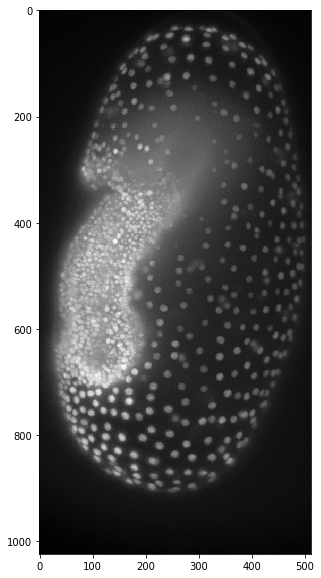

In [4]:
%matplotlib inline

data_location = "E:/Science/Data/Lund Zenodo/"
index = 240
filename = 'lund_i{0:06d}_oi_{1:06d}.tif'.format(metadata.index[index], metadata.original_index[index])
tribolium = imread(data_location + filename)

plt.figure(figsize=(10,10))
cle.imshow(tribolium)

In [5]:
filename[:-3]

'lund_i000240_oi_001352.'

In [6]:
# This workflow does a good job of approximating cellular regions around the nuclei
def workflow(image, number_of_dilations = 10, number_of_erosions = 4):
    import numpy as np
    import pyclesperanto_prototype as cle    

    gpu_input = cle.push(image)

    # Spot detection
    # After some noise removal/smoothing, we perform a local maximum detection

    # gaussian blur -> needs adjusting, maybe even other filters for preprocessing
    gpu_tophat = cle.top_hat_sphere(gpu_input,radius_x=7, radius_y=7, radius_z=7)
    gpu_blurred = cle.gaussian_blur(gpu_tophat, sigma_x=1, sigma_y=1, sigma_z=2) 
    gpu_input = None
    # detect maxima: instead of a pointslist we get and image with white pixels at the maxima locations
    gpu_detected_maxima = cle.detect_maxima_box(gpu_blurred)
    gpu_tophat = None
    # Spot curation
    # Now, we remove spots with values below a certain intensity and label the remaining spots

    # threshold
    gpu_thresholded = cle.threshold_otsu(gpu_blurred)
    gpu_blurred = None

    # mask
    gpu_masked_spots = cle.mask(gpu_detected_maxima, gpu_thresholded)
    gpu_detected_maxima = None
    gpu_thresholded = None
    # label spots
    gpu_labelled_spots = cle.connected_components_labeling_box(gpu_masked_spots)
    gpu_masked_spots = None
    
    number_of_spots = cle.maximum_of_all_pixels(gpu_labelled_spots)
    print("Number of detected spots: " + str(number_of_spots))
    # retrieve the image to take a look at the maxima in napari
    # label map closing

    flip = cle.create_like(gpu_labelled_spots)
    flop = cle.create_like(gpu_labelled_spots)
    flag = cle.create([1,1,1])
    cle.copy(gpu_labelled_spots, flip)

    for i in range (0, number_of_dilations) :
        cle.onlyzero_overwrite_maximum_box(flip, flag, flop)
        cle.onlyzero_overwrite_maximum_diamond(flop, flag, flip)
    
    gpu_labelled_spots = None
    
    flap = cle.greater_constant(flip, constant= 1)

    for i in range(0, number_of_erosions):
        cle.erode_box(flap, flop)
        cle.erode_sphere(flop, flap)

    gpu_labels = cle.mask(flip, flap)
    flip = None
    flop = None
    flap = None
    flag = None
    
    alllabels = cle.close_index_gaps_in_label_map(gpu_labels)
    output = cle.pull(alllabels)
    alllabels = None
    print('Label Numbering Starts at {val}'.format(val = np.min(output[np.nonzero(output)])))
    print('Workflow Completed')
    return output

In [7]:
outdir =     "E:\Science\Data\Lund Zenodo\Processed"
ski_outdir = "E:/Science/Data/Lund Zenodo/Processed/"
if not os.path.exists(outdir):
    os.makedirs(outdir)
    
for i in (range(47,len(metadata))):
    if i != 361:
        filename = 'lund_i{0:06d}_oi_{1:06d}.tif'.format(metadata.index[i], metadata.original_index[i])
        image = imread(data_location + filename)

        rescaled = cle.pull(cle.resample(cle.push(image), 
                                         factor_x=voxel_size_zyx[2], 
                                         factor_y=voxel_size_zyx[1], 
                                         factor_z=voxel_size_zyx[0]))
        imsave(ski_outdir + "rescaled_" + filename, rescaled)

        labels = workflow(rescaled)
        imsave(ski_outdir + "label_image_" + filename, labels)

        region_properties = pd.DataFrame(get_regprops_from_regprops_source(intensity_image = rescaled, 
                                                                           label_image = labels, 
                                                                           region_props_source = 'neighborhood', 
                                                                           n_closest_points_list= [2,3,4]))
        region_properties.to_csv(ski_outdir + "regionproperties_" + filename[:-3] + "csv")

Number of detected spots: 103103.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\517414965.py:18: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000047_oi_000289.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


MemoryError: clEnqueueNDRangeKernel failed: MEM_OBJECT_ALLOCATION_FAILURE

- started at frame 30 since first frames causedmemory failure due to many spots being detected
- frame47 has the same problem
- instead of selecting which frames to compute we will skip the regionproperties as they are causing the memory allocation errors (too many cells for computation of neighbourhoodmatrices

In [11]:
for i in (range(382,len(metadata))):
    if i != 361:
        filename = 'lund_i{0:06d}_oi_{1:06d}.tif'.format(metadata.index[i], metadata.original_index[i])
        image = imread(data_location + filename)

        rescaled = cle.pull(cle.resample(cle.push(image), 
                                         factor_x=voxel_size_zyx[2], 
                                         factor_y=voxel_size_zyx[1], 
                                         factor_z=voxel_size_zyx[0]))
        imsave(ski_outdir + "rescaled_" + filename, rescaled)

        labels = workflow(rescaled)
        imsave(ski_outdir + "label_image_" + filename, labels)
        
        '''
        region_properties = pd.DataFrame(get_regprops_from_regprops_source(intensity_image = rescaled, 
                                                                           label_image = labels, 
                                                                           region_props_source = 'neighborhood', 
                                                                           n_closest_points_list= [2,3,4]))
        region_properties.to_csv(ski_outdir + "regionproperties_" + filename[:-3] + "csv")
        '''
        

Number of detected spots: 1573.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000382_oi_002366.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1573.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000383_oi_002366.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1521.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000384_oi_002367.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1521.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000385_oi_002367.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1651.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000386_oi_002368.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1651.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000387_oi_002368.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1657.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000388_oi_002369.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1657.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000389_oi_002369.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1541.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000390_oi_002370.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1541.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000391_oi_002370.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1555.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000392_oi_002371.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1555.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000393_oi_002371.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1556.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000394_oi_002372.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1556.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000395_oi_002372.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1640.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000396_oi_002373.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1640.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000397_oi_002373.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1648.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000398_oi_002374.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1648.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000399_oi_002374.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1583.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000400_oi_002375.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1583.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000401_oi_002375.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1535.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000402_oi_002376.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1535.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000403_oi_002376.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1523.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000404_oi_002377.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1523.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000405_oi_002377.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1624.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000406_oi_002378.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1624.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000407_oi_002378.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1506.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000408_oi_002380.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1506.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000409_oi_002380.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1506.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000410_oi_002380.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1506.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000411_oi_002380.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1519.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000412_oi_002381.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1519.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000413_oi_002381.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1585.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000414_oi_002382.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1585.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000415_oi_002382.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1618.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000416_oi_002383.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1618.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000417_oi_002383.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1571.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000418_oi_002384.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1571.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000419_oi_002384.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1526.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000420_oi_002385.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1526.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000421_oi_002385.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1485.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000422_oi_002386.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1485.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000423_oi_002386.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1463.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000424_oi_002387.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1463.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000425_oi_002387.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1582.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000426_oi_002388.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1582.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000427_oi_002388.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1468.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000428_oi_002389.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1468.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000429_oi_002389.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1494.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000430_oi_002390.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


Number of detected spots: 1494.0
Label Numbering Starts at 1
Workflow Completed


C:\Users\ryans\AppData\Local\Temp\ipykernel_14016\243934619.py:13: UserWarning: E:/Science/Data/Lund Zenodo/Processed/label_image_lund_i000431_oi_002390.tif is a low contrast image
  imsave(ski_outdir + "label_image_" + filename, labels)


382 failed for some reason so the pictures will be downloaded again and we'll try it once more. That worked so now we will look at how many cells each image has to be able to find which images we're causing crashes for regionprops:

In [13]:
import numpy as np 
np.max(labels)

1493

In [15]:
from dask.array.image import imread
file_name_glob = 'label_image_lund_i*.tif'
dask_stack_labels = imread(ski_outdir + file_name_glob)
dask_stack_labels

,Array,Chunk
Bytes,86.20 GiB,204.80 MiB
Shape,"(431, 213, 710, 355)","(1, 213, 710, 355)"
Count,431 Tasks,431 Chunks
Type,uint32,numpy.ndarray


In [16]:
cell_numbers = [np.max(label_image) for label_image in dask_stack_labels]

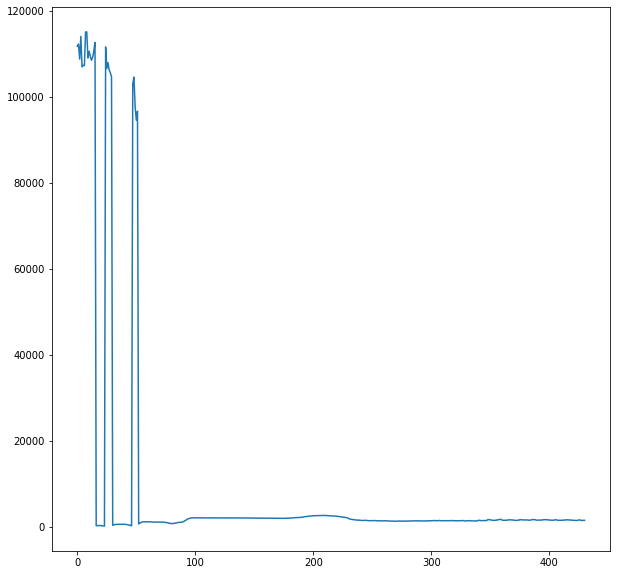

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize = (10,10))
ax.plot(range(len(metadata)-1),cell_numbers)

In [20]:
cellnumber_dict = {'segmented_cells':cell_numbers}
cell_numbers_df = pd.DataFrame(cellnumber_dict)

In [25]:


cell_numbers_df.set_index(index_numbers)
cell_numbers_df.to_csv(ski_outdir + 'segmented_cell_numbers.csv', )
cell_numbers_df

,segmented_cells
0,"dask.array<amax-aggregate, shape=(), dtype=uin..."
1,"dask.array<amax-aggregate, shape=(), dtype=uin..."
2,"dask.array<amax-aggregate, shape=(), dtype=uin..."
3,"dask.array<amax-aggregate, shape=(), dtype=uin..."
4,"dask.array<amax-aggregate, shape=(), dtype=uin..."
...,...
426,"dask.array<amax-aggregate, shape=(), dtype=uin..."
427,"dask.array<amax-aggregate, shape=(), dtype=uin..."
428,"dask.array<amax-aggregate, shape=(), dtype=uin..."
429,"dask.array<amax-aggregate, shape=(), dtype=uin..."


In [24]:
advanced_metadata = pd.concat([metadata,cell_numbers_df], axis = 1)
advanced_metadata.iloc[361]

Unnamed: 0                                                       361
time_in_s                                                108339.5098
original_index                                                  2355
index                                                            361
segmented_cells    dask.array<amax-aggregate, shape=(), dtype=uin...
Name: 361, dtype: object

In [26]:
cell_numbers_computed = [np.max(label_image).compute() for label_image in dask_stack_labels]

In [27]:
cell_numbers_computed

[111865,
 112364,
 108871,
 114159,
 107069,
 107432,
 107358,
 115188,
 115202,
 109113,
 110702,
 109549,
 108608,
 109260,
 110738,
 112740,
 247,
 265,
 270,
 273,
 272,
 234,
 187,
 152,
 111703,
 106661,
 108059,
 106343,
 105682,
 104720,
 358,
 430,
 539,
 552,
 562,
 572,
 568,
 576,
 571,
 576,
 575,
 542,
 516,
 435,
 381,
 319,
 222,
 103097,
 104691,
 97913,
 94665,
 96721,
 643,
 899,
 975,
 1108,
 1161,
 1160,
 1164,
 1159,
 1169,
 1162,
 1154,
 1106,
 1093,
 1094,
 1078,
 1080,
 1073,
 1068,
 1080,
 1074,
 1083,
 1044,
 1023,
 984,
 964,
 895,
 828,
 744,
 738,
 749,
 780,
 829,
 898,
 959,
 1022,
 1015,
 1037,
 1122,
 1187,
 1363,
 1523,
 1726,
 1875,
 1950,
 2010,
 2069,
 2079,
 2073,
 2076,
 2077,
 2068,
 2080,
 2072,
 2074,
 2061,
 2072,
 2049,
 2059,
 2058,
 2070,
 2073,
 2062,
 2041,
 2072,
 2046,
 2069,
 2057,
 2054,
 2056,
 2051,
 2059,
 2060,
 2056,
 2047,
 2078,
 2032,
 2037,
 2051,
 2034,
 2055,
 2058,
 2030,
 2050,
 2050,
 2049,
 2045,
 2042,
 2045,
 2028,
 

In [48]:
index_numbers = pd.Index([i for i in range(len(metadata)) if i != 361])
index_numbers

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            422, 423, 424, 425, 426, 427, 428, 429, 430, 431],
           dtype='int64', length=431)

In [58]:
cellnumber_dict = {'segmented_cells':cell_numbers_computed}
cell_numbers_df = pd.DataFrame(cellnumber_dict,index=index_numbers)
cell_numbers_df.to_csv(ski_outdir + 'segmented_cell_numbers.csv', )

segmented_cells    1508
Name: 362, dtype: int32

In [83]:
advanced_metadata = pd.concat([metadata,cell_numbers_df], axis = 1)
advanced_metadata.iloc[361]

Unnamed: 0            361.0000
time_in_s          108339.5098
original_index       2355.0000
index                 361.0000
segmented_cells            NaN
Name: 361, dtype: float64

In [84]:
visited_indices = []
duplicate = []
for i in advanced_metadata['original_index'].tolist():
    if i in visited_indices:
        duplicate.append(True)
    else:
        duplicate.append(False)
    visited_indices.append(i)
    
duplicate_df = pd.DataFrame({'duplicate_oi':duplicate})
duplicate_df

,duplicate_oi
0,False
1,False
2,False
3,False
4,False
...,...
427,True
428,False
429,True
430,False


In [85]:
advanced_metadata = pd.concat([advanced_metadata,duplicate_df], axis = 1)

In [74]:
if str(advanced_metadata['segmented_cells'].tolist()[361]) == 'nan':
    print('noice')

noice


In [90]:
load_image = []
for duplicate,cellnumber in zip(advanced_metadata['duplicate_oi'].tolist(),
                                advanced_metadata['segmented_cells'].tolist()):
    if duplicate or (cellnumber > 5000):
        load_image.append(False)
    else:
        load_image.append(True)

load_image_df = pd.DataFrame({'load_image' : load_image})
load_image_df

,load_image
0,False
1,False
2,False
3,False
4,False
...,...
427,False
428,True
429,False
430,True


In [93]:
final_metadata = pd.concat([advanced_metadata,load_image_df], axis = 1)
final_metadata.drop(['Unnamed: 0','index'], axis = 1)

,time_in_s,original_index,segmented_cells,duplicate_oi,load_image
0,0.0000,0,111865.0,False,False
1,419.9778,5,112364.0,False,False
2,779.9945,7,108871.0,False,False
3,960.0141,8,114159.0,False,False
4,1320.0067,10,107069.0,False,False
...,...,...,...,...,...
427,128139.6458,2388,1581.0,True,False
428,128739.9586,2389,1467.0,False,True
429,128739.9586,2389,1467.0,True,False
430,129339.7183,2390,1493.0,False,True


In [94]:
final_metadata.to_csv(ski_outdir + 'advanced_metadata.csv')